https://towardsdatascience.com/how-to-simulate-financial-portfolios-with-python-d0dc4b52a278

In [1]:
# Asset Path
import numpy as np

def GBMsimulator(seed, So, mu, sigma, Cov, T, N):
    """
    Parameters

    seed:   seed of simulation
    So:     initial stocks' price
    mu:     expected return
    sigma:  volatility
    Cov:    covariance matrix
    T:      time period
    N:      number of increments
    """

    np.random.seed(seed)
    dim = np.size(So)
    t = np.linspace(0., T, int(N))
    A = np.linalg.cholesky(Cov)
    S = np.zeros([dim, int(N)])
    S[:, 0] = So
    for i in range(1, int(N)):    
        drift = (mu - 0.5 * sigma**2) * (t[i] - t[i-1])
        Z = np.random.normal(0., 1., dim)
        diffusion = np.matmul(A, Z) * (np.sqrt(t[i] - t[i-1]))
        S[:, i] = S[:, i-1]*np.exp(drift + diffusion)
    return S, t

In [2]:
import pandas_datareader as pdr
from datetime import datetime

intc = pdr.get_data_yahoo(symbols='INTC', start=datetime(2018, 1, 1), end=datetime(2020, 1, 1))
amd = pdr.get_data_yahoo(symbols='AMD', start=datetime(2018, 1, 1), end=datetime(2020, 1, 1))

In [3]:
intc.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,46.900002,46.209999,46.380001,46.849998,23370800.0,42.406265
2018-01-03,46.209999,43.650002,45.470001,45.259998,116479000.0,40.967075
2018-01-04,44.650002,42.689999,43.520000,44.430000,89209100.0,40.215805
2018-01-05,45.150002,43.900002,44.430000,44.740002,41824000.0,40.496395
2018-01-08,44.840000,43.959999,44.270000,44.740002,33733800.0,40.496395


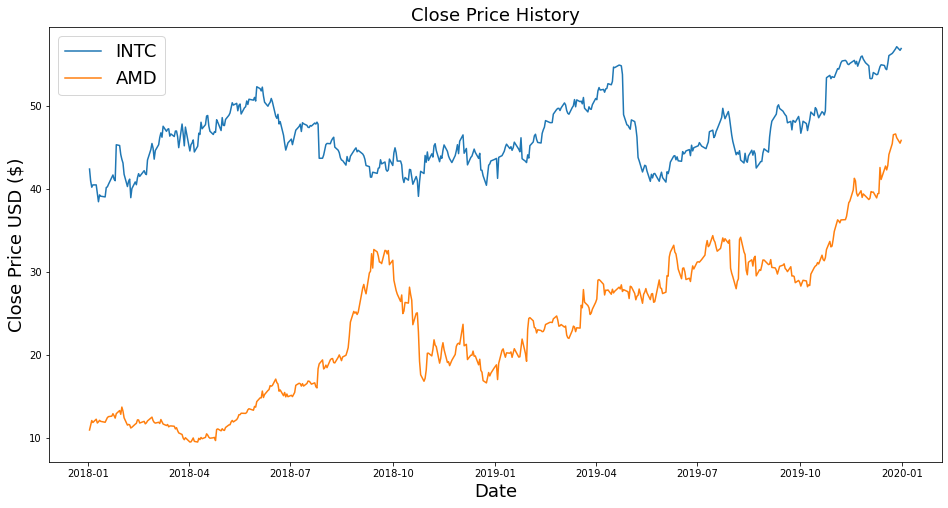

In [4]:
#Visualize the closing price history
import matplotlib.pyplot as plt

plt.figure(figsize = (16,8))
plt.title('Close Price History', fontsize = 18)
plt.plot(intc['Adj Close'])
plt.plot(amd['Adj Close'])
plt.legend(['INTC', 'AMD'], loc = 'upper left', fontsize = 18)
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.show()

In [5]:
# Two-dimensional Case

seed = 22                       

dim = 2; T = 1; N = int(2.**9)

S0 = np.array([100, 100])

# Parameter Estimation

# logarithmic returns

intc['log_returns'] = np.log(intc['Adj Close']).diff()
amd['log_returns'] = np.log(amd['Adj Close']).diff()

# expected returns

mean_intc = intc['log_returns'][1:].mean()
mean_amd = amd['log_returns'][1:].mean()
mu = [mean_intc, mean_amd]

# volatility
std_intc = intc['log_returns'][1:].std()
std_amd = amd['log_returns'][1:].std()
sigma = np.array([std_intc, std_amd])

# covariance matrix
Cov = np.cov(intc['log_returns'][1:], amd['log_returns'][1:] )

stocks, time = GBMsimulator(seed, S0, mu, sigma, Cov, T, N)



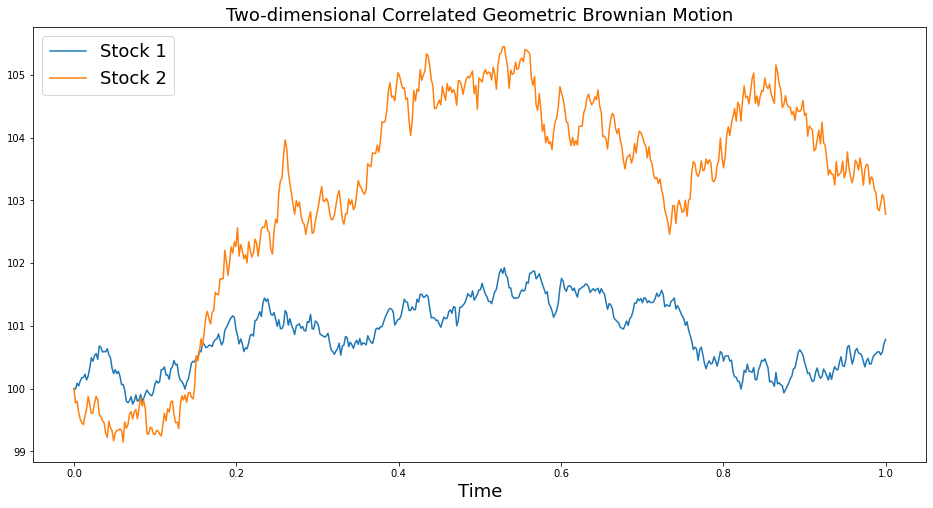

In [6]:
# Visualize Simulation
import matplotlib.pyplot as plt

plt.figure(figsize = (16,8))
plt.title('Two-dimensional Correlated Geometric Brownian Motion', fontsize = 18)
plt.plot(time, stocks[0,:], label='Stock 1')
plt.plot(time, stocks[1,:], label='Stock 2')

plt.xlabel('Time', fontsize = 18)
plt.legend(['Stock 1', 'Stock 2'], loc = 'upper left', fontsize = 18)
plt.show()

In [7]:
# Multidimensional Case
from scipy.stats import random_correlation

seed = 2222                       

dim = 10

T = 1
N = int(2.**9)
S0 = np.random.normal(100, 1, dim)
mu = np.random.uniform(0.01, 0.01, dim)
sigma = np.random.uniform(0.01, 0.1, dim)

# Random Correlated Geometric Bronian Motion
if dim == 1:
    corr = np.array([1])
else:
    eig = np.random.uniform(0.1, 1, dim)
    eig = eig/np.sum(eig)*dim                        # Sum of eigenvalues must equal dimensionality.
    corr = random_correlation.rvs(eig)

Cov = np.tensordot(sigma, sigma, 0) * corr           # covariance matrix

# Uncorrelated Geometric Bronian Motion
#corr = np.identity(dim)

stocks, time = GBMsimulator(seed, S0, mu, sigma, Cov, T, N)

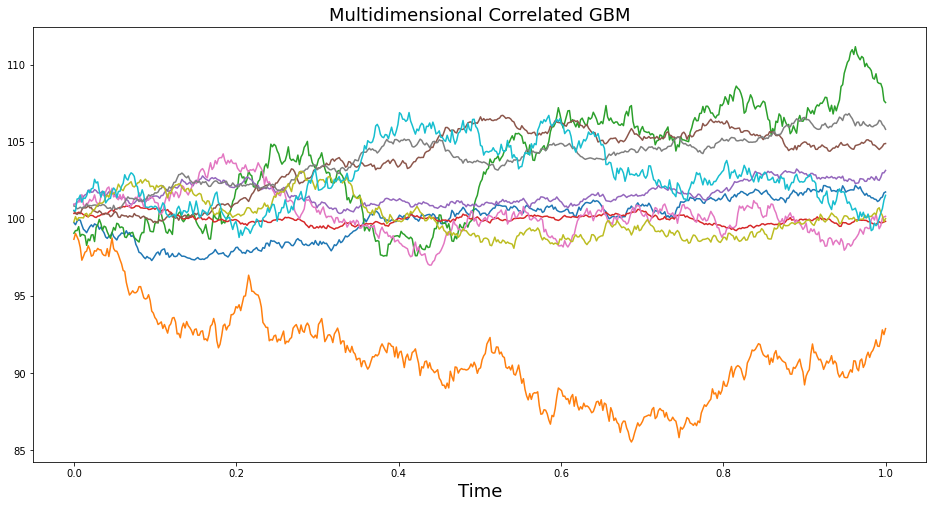

In [8]:
# Number of Simulations

np.random.seed(seed)
simul = int(10)                                       

SS = np.zeros([simul, dim, N])

SS[0, :, :] = stocks

for k in range(1, simul):
    seed = int(np.random.uniform(1,2**32-1,1))
    SS[k, :, :] = GBMsimulator(seed, S0, mu, sigma, Cov, T, N)[0]

# Plot one of the simulations, e.g. the 0th

plt.figure(figsize = (16,8))
plt.title('Multidimensional Correlated GBM', fontsize = 18)
plt.xlabel('Time', fontsize = 18)

for j in range(dim):
    plt.plot(time, SS[0, j, :])
plt.show()

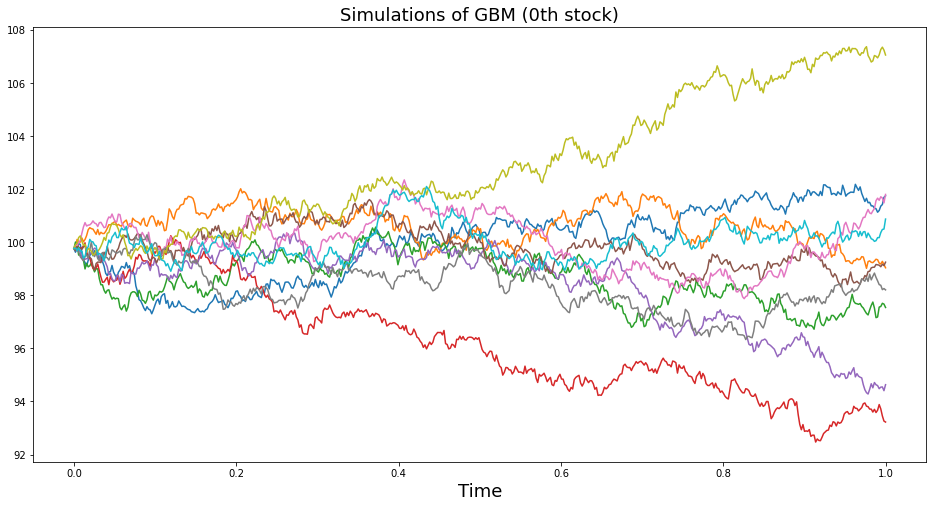

In [9]:
# Plot all simulations of a specific stock, e.g. the 0th

plt.figure(figsize = (16,8))
plt.title('Simulations of GBM (0th stock)', fontsize = 18)
plt.xlabel('Time', fontsize = 18)

for i in range(simul):
    plt.plot(time, SS[i, 0, :])